# LIBRARIES IMPORTATION 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, 
classification_report, ConfusionMatrixDisplay)
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max.column', None)
pd.set_option('display.max.row', None)

# PLOT STYLE

In [3]:
print(plt.style.available)
plt.style.use('tableau-colorblind10')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


# DATA IMPORTATION AND EXPLORATION

About the dataset

The dataset was gotten from Kaggle, it contains a collection of SMS messages. It was manually extracted from the Grumbletext Web site, this is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The objective is to build a Decision Tree classification model that will be able to tell if messages are spam or ham.

In [4]:
df = pd.read_csv(r"C:\Users\DELL\Desktop\Dataset\spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# DATA CLEANING

In [6]:
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

In [7]:
df.duplicated().sum()

np.int64(415)

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df['Label'] = df['Category'].map({'ham' : 0, 'spam' : 1})

In [10]:
df.head()

,Category,Message,Label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
df['Category'].value_counts()

Category
ham     4516
spam     641
Name: count, dtype: int64

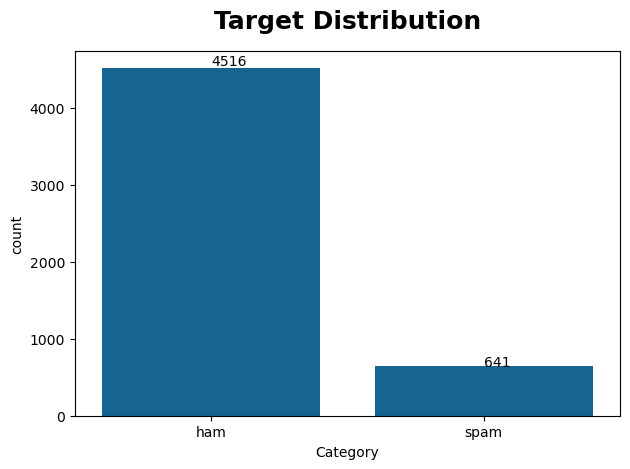

In [12]:
# A count plot to visualize the distribution of Target (spam or ham)
g = sns.countplot(x = df['Category'])
g.set_title('Target Distribution', fontsize = 18, y = 1.04, fontweight = 'bold')
for bar in g.patches:
    height = bar.get_height()
    width = bar.get_width() / 2 
    g.text(bar.get_x() + width, height + (height * 0.01), f'{int(height)}')
plt.tight_layout()
plt.show()


# DATA SPLITTING

In [13]:
y = df['Label']
X = df['Message']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4125,) (1032,) (4125,) (1032,)


TFIDF stands for TERM FREQUENCY INVERSE DOCUMENT FREQUENCY: it is a technique used to turn text into numbers so a machine learning model can understand. 
TERM FREQUENCY: is how often a word appear in a document.
INVERSE DOCUMENT FREQUENCY: It reduces the important of common words.
TFIDF is a vectorizer tool to find words that are important in a document by blancing frequency and uniquness. 


In [15]:
tfidf = TfidfVectorizer(stop_words = 'english')
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [16]:
smote = SMOTE(random_state = 42)
X_train_resample, y_train_resample = smote.fit_resample(X_train_vec, y_train)

In [17]:
y_train_resample.value_counts()

Label
0    3612
1    3612
Name: count, dtype: int64

In [18]:
model = DecisionTreeClassifier(random_state = 42)

In [19]:
param = model.get_params()
print(f'Decision Tree Classifier Parameters \n {param}')

Decision Tree Classifier Parameters 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


HYPERPARAMETER TUNING: Hyperparameter is a configuration setting used to control the learning process, 
These hyperparameter are not learnt from the data, they are usually set manually before the training begins. 
The goal of hyperparameter is to improve  the performance of the model and help the model learn well. 

There are two major techniques:
GridsearchCV tries all possible combination of hyperparameter from a predefined grid, It uses cross validation, splitting the data 
into different folds and evaluating them. it is usually slow but give best hyperprameter using scoring metrics such as accuracy,
roc_auc, recall. e.t.c it searches exhaustively for the best combinations of  hyperparameters.

RandomizedSearchCv randomly samples a fixed number of hyperparameter from a distribution. it is useful when the search space is large.
It is fast, it gives better hyperparameters but might miss the best hyperparameter.

Key Hyperparameters:

criterion: Entropy measures the disorder of the split. 

max_depth: The maximum depth of the tree (how deep the tree should be). The deeper a tree is, the more complex it becomes which is prone to overfitting.

min_samples_split: Minimum sample to split at an internal node.

min_samples_leaf: The minimum number of samples required at the leaf node, larger values help imbalanced data).

class_weight: Balanced very important for imbalanced datasets

max_features: sqrt or log2 (controls randomness and generalization). This limits the number of features to be considered when looking for the best split at each node.

In [20]:
grid = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 4, 6, 8],
    "max_features": [None, "sqrt", "log2", 0.8],
    "criterion": ["gini", "entropy", "log_loss"],  # splitting criteria
    "min_samples_leaf": [1, 2, 4]  # useful to prevent overfitting
}

In [21]:
model_grid = RandomizedSearchCV(estimator = model, param_distributions = grid, scoring = "f1", cv = 5,
                           n_iter = 100, verbose = 2, n_jobs = -1)
print('Starting Grid Search')
model_grid.fit(X_train_resample, y_train_resample)
# To extract the best hyperparameter
best_hyperparameter = model_grid.best_params_
print(f'Best hyperparameter \n {best_hyperparameter}')
#  To extract the best score
best_cv_score = model_grid.best_score_
print(f'Best Score \n {best_cv_score}')

Starting Grid Search
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best hyperparameter 
 {'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': None, 'criterion': 'log_loss'}
Best Score 
 0.9784348482000862


In [22]:
best_model = model_grid.best_estimator_
y_best_pred =  best_model.predict(X_test_vec)

In [23]:
print(f'Accuracy Score {accuracy_score(y_test, y_best_pred):.2f}')
print(f'Precision Score {precision_score(y_test, y_best_pred):.2f}')
print(f'Recall Score {recall_score(y_test, y_best_pred):.2f}')
print(f'F1 Score {f1_score(y_test, y_best_pred):.2f}')

Accuracy Score 0.96
Precision Score 0.87
Recall Score 0.75
F1 Score 0.81


In [24]:
print(f'Classification Report \n {classification_report(y_test, y_best_pred)}')

Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       904
           1       0.87      0.75      0.81       128

    accuracy                           0.96      1032
   macro avg       0.92      0.87      0.89      1032
weighted avg       0.95      0.96      0.95      1032



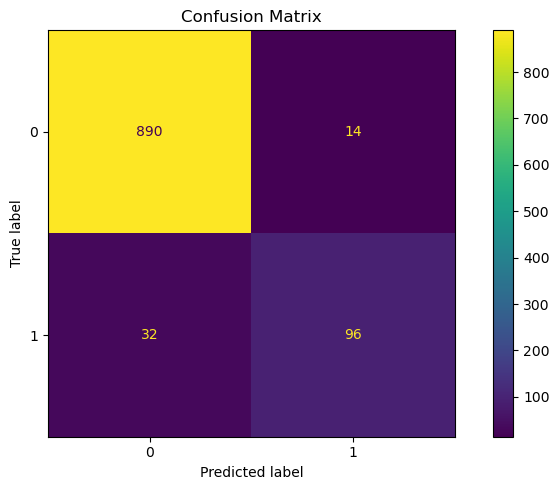

In [26]:
cm = confusion_matrix(y_test, y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
disp.plot(ax = ax)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

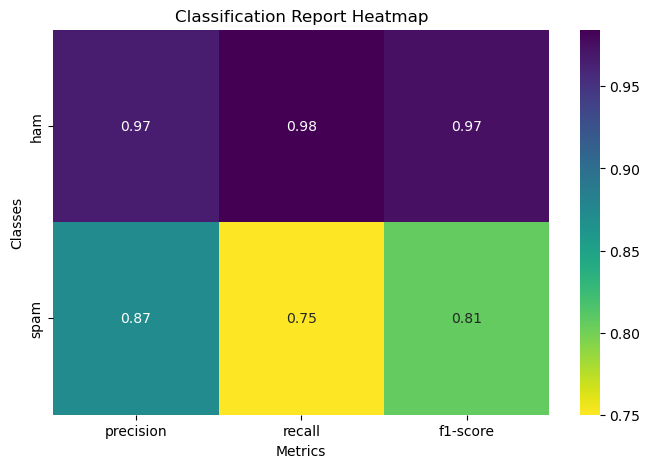

In [27]:
cr = classification_report(y_test, y_best_pred, zero_division = 0, output_dict = True, target_names = ['ham', 'spam'])
# Convert classification report into a data frame.
cr_df = pd.DataFrame(cr).transpose()
# To drop support column and last three rows (accuracy, macro avg and weighted avg)
heatmap = cr_df.iloc[: -3, :].drop(['support'], axis = 1)
plt.figure(figsize = (8, 5))
sns.heatmap(heatmap, annot = True, fmt = '.2f', cmap = 'viridis_r')
plt.title("Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()

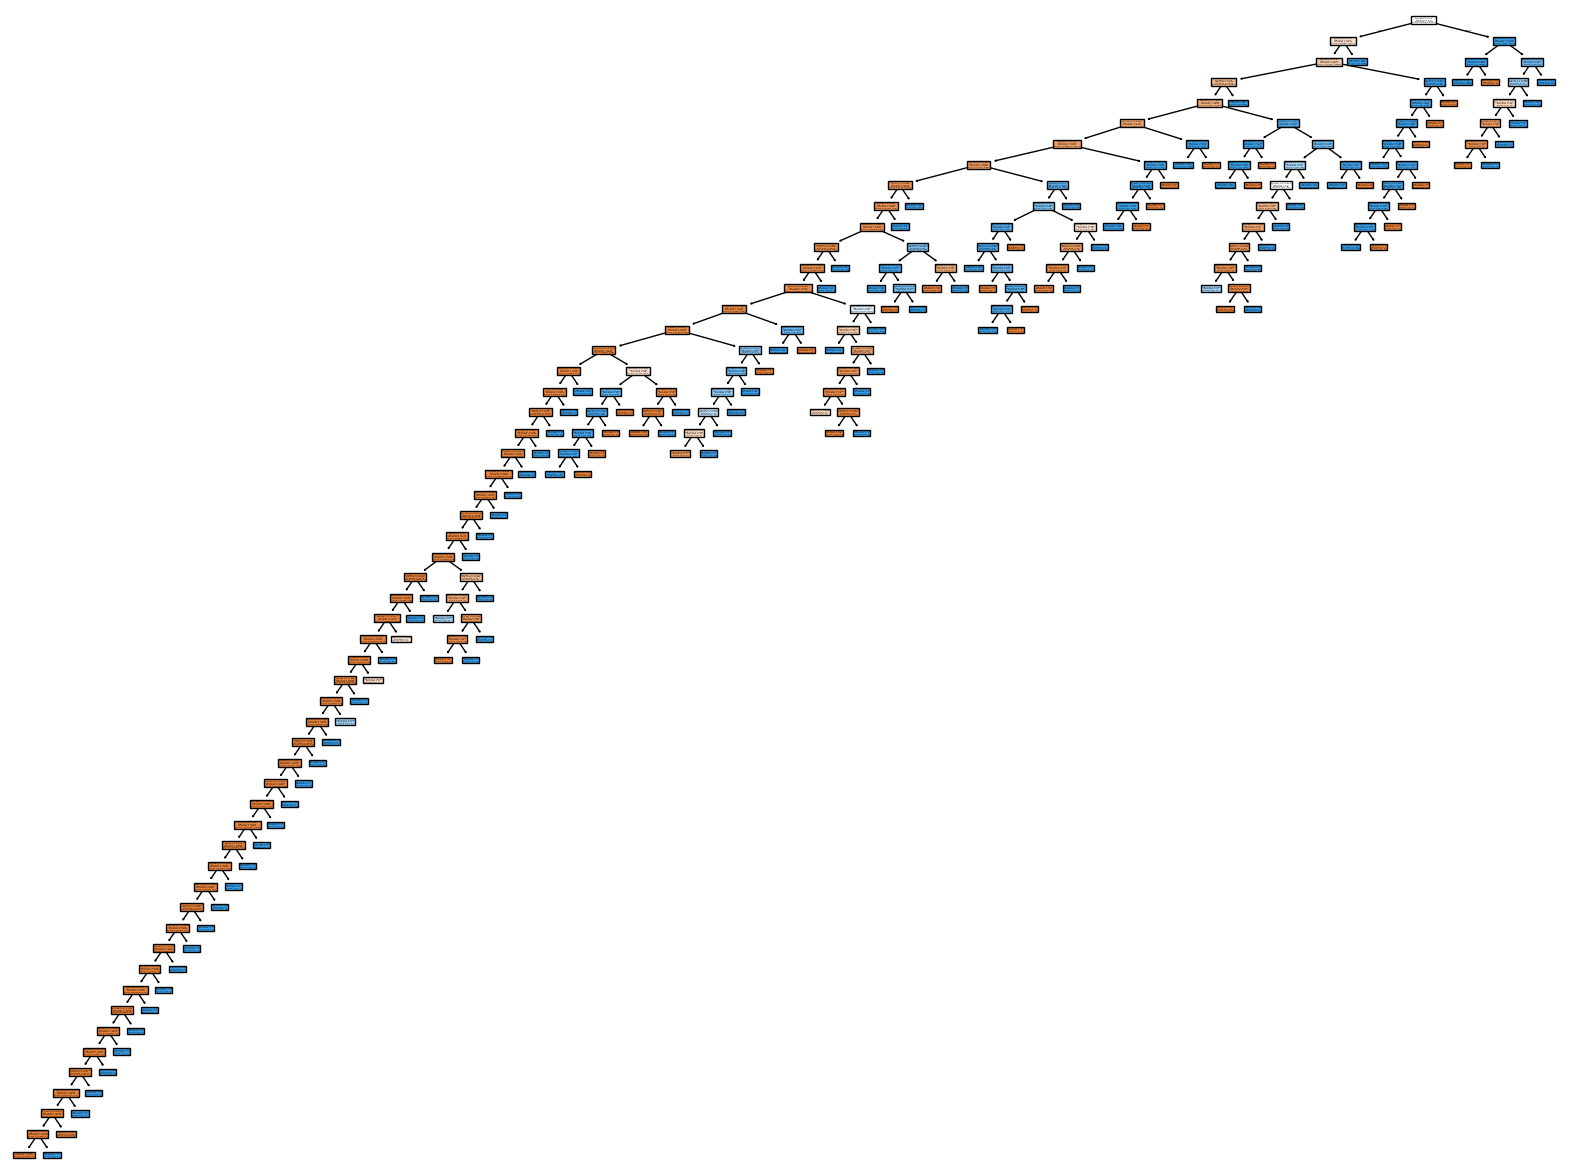

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(20, 15))
plot_tree(best_model, filled = True)
ax.set_title('How Decision made it Decision', fontsize = 15)
plt.show()
plt.tight_layout()